# Import Packages

In [13]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange
import h5py

# Define Parameters

In [14]:
SNR = 175
n_elements = 128

ob_weight = 100
Nth = 10

n_noise_realizations = 10
n_datasets = 5

lambdas = np.append(0, np.logspace(-7,3,51))

upper_bound = [1,1,500,1500] #Set upper bound on parameters c1, c2, T21, T22, respectively
initial = (0.5, 0.5, 250, 750) #Set initial guesses
agg_array = np.array([1,1,1/ob_weight, 1/ob_weight])

tdata = np.linspace(0, 635, n_elements)

noise_sd = 1/SNR

c1_set = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
c2_set = 1 - c1_set
T21_set = np.array([10, 20, 30, 40, 50, 60])
T22_set = np.array([70, 85, 100, 120, 150, 200])
n_param_sets = c1_set.size * T21_set.size * T22_set.size

SNR_set = np.array([10, 50, 100, 175, 300])



# Define Signal Functions

In [15]:
#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def noise(sd):
    return np.random.normal(0, sd, n_elements)

def add_noise(signal, SNR):
    #Given a noiseless signal, adds noise at given SNR and returns a noisy signal
    signal_length = len(signal)
    noise_sd = signal[0]/SNR
    noisy_signal = signal + np.random.normal(0, noise_sd, signal_length)
    return noisy_signal

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, noise_sd):
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2)
    covariance = np.linalg.inv(jacobians)
    return noise_sd**2*covariance

# Define Regularization and Estimation Functions

In [54]:
def estimate_parameters(data, lam):
    data_tilde = np.append(data, [0,0,0,0])
    
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
        
    return c1est, c2est, T21est, T22est

def min_lambda(data, c1, c2, T21, T22, lambdas = np.logspace(-7, 3, 51), agg_arr = np.array([1, 1,1/ob_weight,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, 
    
def find_minLambda_omni_L2(noisey_data, c1, c2, T21, T22, lambdas = np.logspace(-7, 3, 51), agg_arr = np.array([1, 1,1/ob_weight,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(noisey_data, lam))
        estimates.append(est)
        error = np.linalg.norm((est-p_true).dot(agg_arr))
        abs_error_list.append(error)
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list

def find_minLambda_omni_L1(noisey_data, c1, c2, T21, T22, lambdas = np.logspace(-7, 3, 51), agg_arr = np.array([1, 1,1/ob_weight,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(noisey_data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list

def min_bias_estimates(c1, c2, T21, T22, n=100, lambdas = np.logspace(-7,3, 51), agg_arr = [1,1,0.01,0.01]):
    #Returns aggregate bias, variance, and MSE of the estimates generated 
    #from using the lambda which minimizes bias for each noise realization
    agg_arr = np.array(agg_arr)
    underlying = G(tdata, c1, c2, T21, T22)
    
    bias = np.zeros(4)
    variance = np.zeros(4)
    MSE = np.zeros(4)
    
    min_bias_lambdas = []
    min_bias_estimates = []
    for i in range(n):
        np.random.seed(i)
        data = underlying + noise(noise_sd)
        agg_bias_list = []
        temp_estimates = []
        for l in range(len(lambdas)):
            lam = lambdas[l]
            est = np.array(estimate_parameters(data, lam))
            temp_estimates.append(est)
            agg_bias_list.append(np.absolute(est-[c1,c2,T21,T22]).dot(agg_arr))
        
        min_bias_idx = np.argmin(agg_bias_list)
        
        min_bias_lambdas.append(lambdas[min_bias_idx])
        min_bias_estimates.append(temp_estimates[min_bias_idx])
    
    min_bias_estimates = np.array(min_bias_estimates)
    
    c1est = min_bias_estimates[:,0]
    c2est = min_bias_estimates[:,1]
    T21est = min_bias_estimates[:,2]
    T22est = min_bias_estimates[:,3]
    
    bias[0] = (c1est - [c1]*n).sum()/n
    bias[1] = (c2est - [c2]*n).sum()/n
    bias[2] = (T21est - [T21]*n).sum()/n
    bias[3] = (T22est - [T22]*n).sum()/n
    
    variance[0] = statistics.pvariance(c1est)
    variance[1] = statistics.pvariance(c2est)
    variance[2] = statistics.pvariance(T21est)
    variance[3] = statistics.pvariance(T22est)
    
    MSE = bias**2 + variance
    
    agg_bias = np.absolute(bias).dot(agg_arr)
    agg_variance = variance.dot(agg_arr**2)
    agg_MSE = MSE.dot(agg_arr**2)
    
    return agg_bias, agg_variance, agg_MSE, np.array(min_bias_lambdas)

# Visualize Minimum Lambda - Grid Method

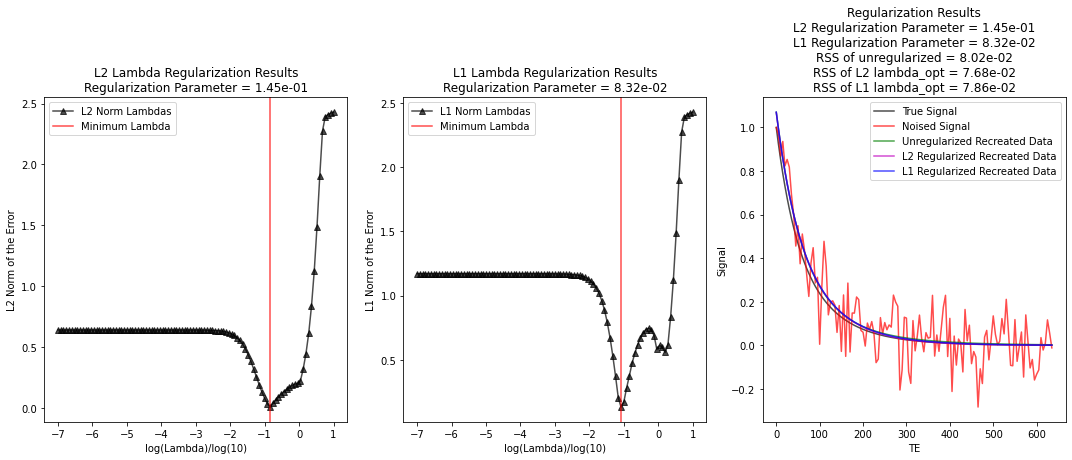

In [59]:
lambdas_test = np.logspace(-7, 1, 101)

noise_sd = 1/10

c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 100

noiseless_curve = G(tdata, c1, c2, T21, T22)

data = noiseless_curve + noise(noise_sd)
data = data/data[0]

unreg_params = estimate_parameters(data, 0)

opt_params_L2, min_error_lambda_L2, error_array_L2 = find_minLambda_omni_L2(data, c1, c2, T21, T22, lambdas = lambdas_test)
opt_params_L1, min_error_lambda_L1, error_array_L1 = find_minLambda_omni_L1(data, c1, c2, T21, T22, lambdas = lambdas_test)

unreg_curve = G(tdata, *unreg_params)
recreated_curve_L2 = G(tdata, *opt_params_L2)
recreated_curve_L1 = G(tdata, *opt_params_L1)

unreg_RSS = np.sum((noiseless_curve - unreg_curve)**2)
recreated_RSS_L2 = np.sum((noiseless_curve - recreated_curve_L2)**2)
recreated_RSS_L1 = np.sum((noiseless_curve - recreated_curve_L1)**2)

fig, ax = plt.subplots(1,3,figsize=(15,6.5), tight_layout=True)
ax[0].plot(np.log10(lambdas_test), error_array_L2, label = 'L2 Norm Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=np.log10(min_error_lambda_L2), label = 'Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[0].set_xlabel('log(Lambda)/log(10)')
ax[0].set_ylabel('L2 Norm of the Error')
ax[0].set_title('L2 Lambda Regularization Results' + '\nRegularization Parameter = ' + "{:.2e}".format(min_error_lambda_L2))
ax[0].legend()

ax[1].plot(np.log10(lambdas_test), error_array_L1, label = 'L1 Norm Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axvline(x=np.log10(min_error_lambda_L1), label = 'Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[1].set_xlabel('log(Lambda)/log(10)')
ax[1].set_ylabel('L1 Norm of the Error')
ax[1].set_title('L1 Lambda Regularization Results' + '\nRegularization Parameter = ' + "{:.2e}".format(min_error_lambda_L1))
ax[1].legend()


ax[2].plot(tdata, noiseless_curve, label = 'True Signal', alpha = 0.7, color ='k', ls = '-')
ax[2].plot(tdata, data, label = 'Noised Signal', alpha = 0.7, color ='r', ls = '-')
ax[2].plot(tdata, unreg_curve, label = 'Unregularized Recreated Data', alpha = 0.7, color ='g', ls = '-')
ax[2].plot(tdata, recreated_curve_L2, label = 'L2 Regularized Recreated Data', alpha = 0.7, color ='m', ls = '-')
ax[2].plot(tdata, recreated_curve_L1, label = 'L1 Regularized Recreated Data', alpha = 0.7, color ='b', ls = '-')
ax[2].set_xlabel('TE')
ax[2].set_ylabel('Signal')
ax[2].set_title('Regularization Results' + '\nL2 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L2) + 
            '\nL1 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L1) +
            '\nRSS of unregularized = ' + "{:.2e}".format(unreg_RSS) + 
            '\nRSS of L2 lambda_opt = ' + "{:.2e}".format(recreated_RSS_L2) + 
            '\nRSS of L1 lambda_opt = ' + "{:.2e}".format(recreated_RSS_L1))
ax[2].legend()

# Generate Data Scheme

In [17]:
#For each true parameter value, generate n_datasets at a certain SNR defined above
for SNR in SNR_set:
    noise_sd = 1/SNR
    with h5py.File('Lambda_TrainingData//Mesh1_SNR_%s.hdf5'%SNR,'a') as f2:
        for c1 in c1_set:
            c2 = 1-c1
            for iT21 in trange(np.size(T21_set)):
                T21 = T21_set[iT21]
                for T22 in T22_set:
                    noiseless_curve = G(tdata, c1, c2, T21, T22)
                    #Generate the datasets from the underlying curve
                    datasets = []
                    lambdaset = []
                    for i in range(n_datasets):
                        np.random.seed(i)
                        data = noiseless_curve + noise(noise_sd)
                        #For brain data, normalize so that the first point is at 1
                        data = data/data[0]
                        datasets.append(data)

                        opt_params, min_error_lambdas = min_lambda(data, c1, c2, T21, T22)
                        lambdaset.append(min_error_lambdas)
    
                    datasets = np.array(datasets)
                    dset = f2.create_dataset('{},{},{},{},x'.format(c1,c2,T21,T22),data=datasets)
                    dset = f2.create_dataset('{},{},{},{},y'.format(c1,c2,T21,T22),data=min_error_lambdas)

100%|██████████| 6/6 [02:30<00:00, 25.16s/it]
